# Quantitative Momentum

*Quantitative Momentum* is an investment strategy which selects for investment the stocks whose price appreciated the most during a period (usually the recent year, ignoring the most recent month).

Not every momentum portfolio performs well, and they have to be carefully managed. With this implementation I am only using data from the past year, and the success of the portfolio will only be determined with time. Backtesting is irrelvant here, but I will compare our portfolio with the Vanguard 500 Index over the last year just to illustrate what the strategy is built upon.

In [25]:
import numpy as np
import pandas as pd
import requests
import math
from scipy import stats

Importing S&P 500 constituents 

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
stocks = pd.read_csv('drive/MyDrive/sp_500_stocks.csv')
stocks

,Ticker
0,A
1,AAL
2,AAP
3,AAPL
4,ABBV
...,...
500,YUM
501,ZBH
502,ZBRA
503,ZION


In [44]:
# you will need your own token to run this yourself. see https://iexcloud.io/

IEX_CLOUD_API_TOKEN = 'INSERT API TOKEN HERE'

In [45]:
# quick test of api call

symbol = 'AAPL'
api_url = f'https://cloud.iexapis.com/stable/stock/{symbol}/stats?token={IEX_CLOUD_API_TOKEN}'
data = requests.get(api_url)
data 

<Response [200]>

### Building a Momentum Strategy



Not every momentum portfolio was created equal.

Simple momentum strategies that crushed the market during the 20’s through the 90’s have changed course and have been lagging the market since 2000.  Only careful momentum implementation, one that relies on findings in recent academic studies, continues to perform well.

Wes Grey and Jack Vogel’s book, *Quantitative Momentum*, proposes several improvements to the momentum strategy which significantly boost returns. They suggest instead of choosing the stocks with the highest momentum (returns during the last year excluding the most recent month), take the highest decile of momentum stocks and select the stocks with the highest momentum quality.

([source](https://taldavidson.com/quantitative-momentum/quantitative-momentum-strategy/))

To identify high-*quality* momentum, we're going to build a strategy that selects stocks from the highest percentiles of:



*   1-month price returns
*   3-month price returns
*   6-month price returns
*   1-year price returns


In [46]:
# limited to 100 stock tickers per API call

# Function sourced from 
# https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]   
        
symbol_groups = list(chunks(stocks['Ticker'], 100))
symbol_strings = []
for i in range(0, len(symbol_groups)):
    symbol_strings.append(','.join(symbol_groups[i]))

In [47]:
hqm_columns = [
                'Ticker', 
                'Price',  
                'One-Year Price Return', 
                'One-Year Return Percentile',
                'Six-Month Price Return',
                'Six-Month Return Percentile',
                'Three-Month Price Return',
                'Three-Month Return Percentile',
                'One-Month Price Return',
                'One-Month Return Percentile',
                'HQM Score'
                ]

hqm_dataframe = pd.DataFrame(columns = hqm_columns)

for symbol_string in symbol_strings:
#     print(symbol_strings)
    batch_api_call_url = f'https://cloud.iexapis.com/stable/stock/market/batch/?types=stats,quote&symbols={symbol_string}&token={IEX_CLOUD_API_TOKEN}'
    data = requests.get(batch_api_call_url).json()
    for symbol in symbol_string.split(','):
        hqm_dataframe = hqm_dataframe.append(
                                        pd.Series([symbol, 
                                                   data[symbol]['quote']['latestPrice'],
                                                   data[symbol]['stats']['year1ChangePercent'],
                                                   0,
                                                   data[symbol]['stats']['month6ChangePercent'],
                                                   0,
                                                   data[symbol]['stats']['month3ChangePercent'],
                                                   0,
                                                   data[symbol]['stats']['month1ChangePercent'],
                                                   0,
                                                   0
                                                   ], 
                                                  index = hqm_columns), 
                                        ignore_index = True)
        
hqm_dataframe.columns

Index(['Ticker', 'Price', 'One-Year Price Return',
       'One-Year Return Percentile', 'Six-Month Price Return',
       'Six-Month Return Percentile', 'Three-Month Price Return',
       'Three-Month Return Percentile', 'One-Month Price Return',
       'One-Month Return Percentile', 'HQM Score'],
      dtype='object')

In [48]:
hqm_dataframe.dropna(inplace=True)

In [49]:
# calculating momentum percentile
time_periods = [
                'One-Year',
                'Six-Month',
                'Three-Month',
                'One-Month'
                ]

for row in hqm_dataframe.index:
    for time_period in time_periods:
        change_col = f'{time_period} Price Return'
        percentile_col = f'{time_period} Return Percentile'
        hqm_dataframe.loc[row, percentile_col] = stats.percentileofscore(hqm_dataframe[change_col], hqm_dataframe.loc[row, change_col])/100


#Print the entire DataFrame    
hqm_dataframe

,Ticker,Price,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile,HQM Score
0,A,150,0.449926,0.678643,0.158824,0.768463,0.017529,0.572854,-0.138634,0.011976,0
1,AAL,20.135,0.520455,0.726547,-0.147409,0.0858283,-0.0392532,0.301397,0.0591029,0.796407,0
2,AAP,212.13,0.396637,0.622754,0.175692,0.802395,0.00807401,0.52495,0.0758063,0.844311,0
3,AAPL,143.08,0.229538,0.391218,0.0779138,0.580838,-0.0137543,0.397206,-0.0407465,0.329341,0
4,ABBV,110.54,0.3305,0.536926,0.0580842,0.528942,-0.0356885,0.315369,0.0421822,0.746507,0
...,...,...,...,...,...,...,...,...,...,...,...
500,YUM,122.06,0.314532,0.508982,0.0818256,0.588822,0.0444476,0.698603,-0.0500423,0.263473,0
501,ZBH,143.89,-0.0029046,0.113772,-0.13206,0.0958084,-0.0780006,0.161677,0.0458819,0.752495,0
502,ZBRA,493.75,0.756092,0.866267,-0.0173002,0.303393,-0.0894601,0.135729,-0.141054,0.00798403,0
503,ZION,62.53,1.0672,0.9501,0.149234,0.742515,0.222203,0.97006,0.106135,0.9002,0


We'll now calculate our HQM Score, which is the high-quality momentum score that we'll use to filter for stocks in this investing strategy.

The HQM Score will be the arithmetic mean of the 4 momentum percentile scores that we calculated in the last section.

In [50]:
from statistics import mean

for row in hqm_dataframe.index:
    momentum_percentiles = []
    for time_period in time_periods:
        momentum_percentiles.append(hqm_dataframe.loc[row, f'{time_period} Return Percentile'])
    hqm_dataframe.loc[row, 'HQM Score'] = mean(momentum_percentiles)

In [51]:
# select top 50
hqm_dataframe = hqm_dataframe.sort_values(by = 'HQM Score', ascending = False)
hqm_dataframe = hqm_dataframe[:51].reset_index(drop=True)

In [52]:
hqm_dataframe

,Ticker,Price,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile,HQM Score
0,DVN,39.48,3.06457,1,0.829867,1,0.396675,0.998004,0.420021,0.994012,0.998004
1,MCHP,144.1,1.59348,0.99002,0.817831,0.998004,1.03563,1,0.855982,1,0.997006
2,FANG,110.805,2.683,0.996008,0.485209,0.99002,0.236152,0.976048,0.464552,0.998004,0.99002
3,MRO,15.955,2.82182,0.998004,0.484143,0.986028,0.217129,0.968064,0.425909,0.996008,0.987026
4,COP,74.01,1.21244,0.968064,0.485073,0.988024,0.255494,0.986028,0.344339,0.988024,0.982535
5,PXD,193.32,1.24899,0.974052,0.334358,0.962076,0.238721,0.982036,0.282233,0.98004,0.974551
6,MOS,41.995,1.06668,0.948104,0.289338,0.9501,0.273809,0.992016,0.27124,0.978044,0.967066
7,CF,62.225,1.00572,0.934132,0.342793,0.966068,0.212711,0.964072,0.337862,0.986028,0.962575
8,OXY,33.435,2.11311,0.992016,0.368648,0.972056,0.112548,0.886228,0.346277,0.99002,0.96008
9,SIVB,668.5,1.44134,0.986028,0.347204,0.968064,0.165583,0.944112,0.13335,0.932136,0.957585


### Performance

As I mentioned in the introduction, true performance will only be told with time. However, to illustrate what our portfolio is built upon, I will compare the year to date gains it would have generated vs the popular Vanguard 500 Index. 

Keep in mind this portfolio was built using this data, so we are expecting it to outperform the Vanguard 500 by a lot. 

Portfolio was built using the top 20 highest HQM score stocks. $100000 was equally allocated between the stocks.

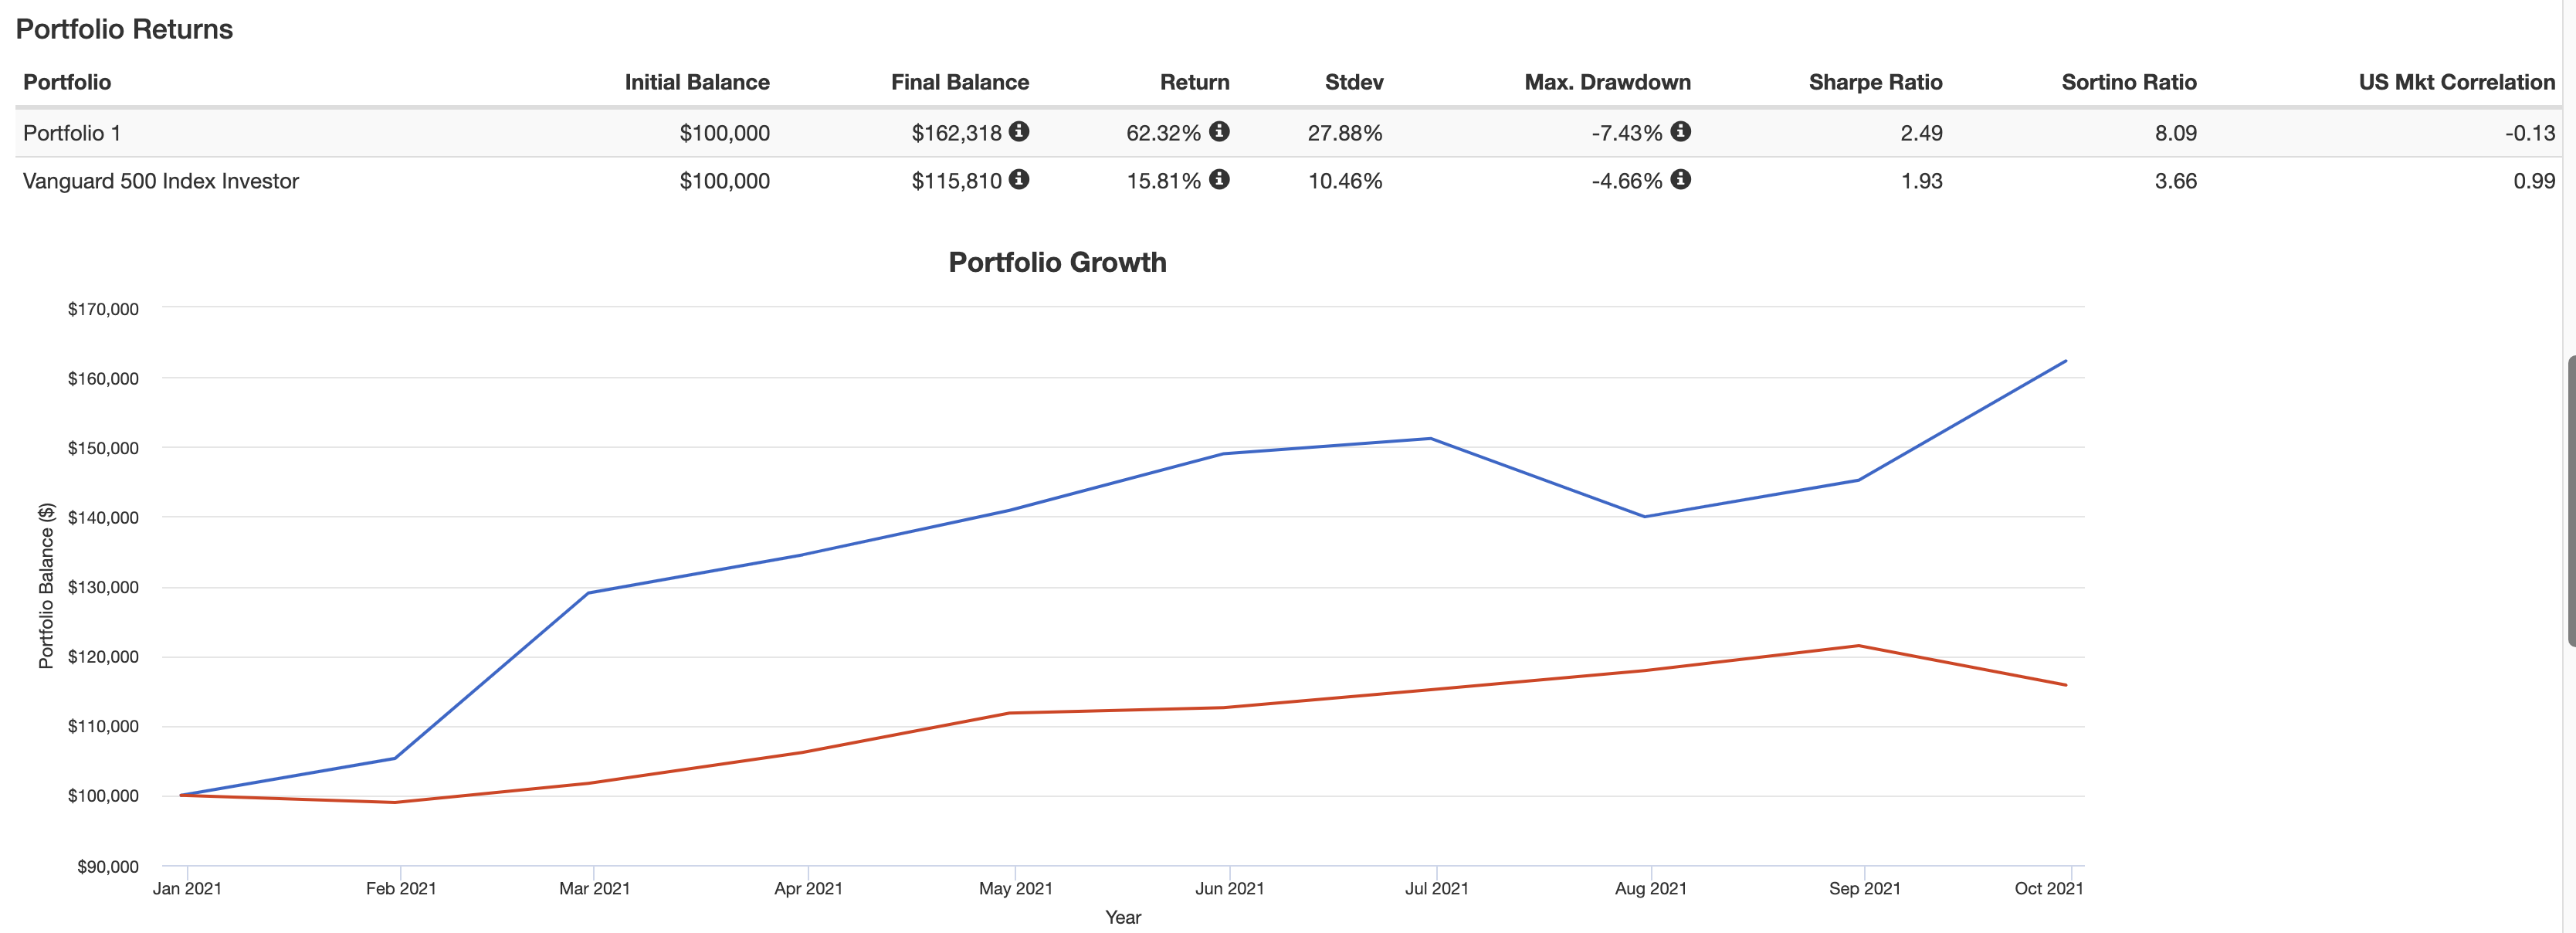

I will update in a few months/year to see how exactly this strategy plays out. Short term success may be there, but without careful management and rebalancing, I will certainly be outperformed by other indexes.